In [9]:
import sys
# Req for package
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, set_seed, DEVICE, kfcv, get_parameter_loss
from SkinLearning.Utils.Dataset import get_dataset, get_split
from SkinLearning.Utils.Plotting import print_curves, plot_parameter_bars
from SkinLearning.NN.Models import MultiTemporal

import seaborn as sns

# Dataset

In [4]:
dataset, scaler = get_dataset() # Can also specify specific runs

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:08<00:00, 249.68it/s]


In [5]:
# Default 80/20 split wrapped in torch DataLoader with 32 batch size
train_loader, test_loader = get_split(dataset)

# Model

In [2]:
model = MultiTemporal(
    conv=True, # Default value, will use best CNN module
    out="f_hidden", # f_hidden, f_output, output, hidden, h+o
    temporal_type="RNN",
    single_fc=True, # FC x1 or FC x3
    attention=False, # In progress attention mechanism...
    fusion_method="concatenate" # How the feature vector is handled when CNN not used
)

FC in: 256 HS 256


# Training/Testing

In [21]:
losses, val_losses = train(
    train_loader,
    model,
    val_loader=test_loader, # If given will test validation set after every epoch
    early_stopping=True, # Stops after no increase in validation set after patience value
    patience=50,
    epochs=5,
    plot=False # If true will plot train/val curves dynamically in notebook
)

Using: cuda


100%|██████████████████████████| 113/113 [00:01<00:00, 93.05batch/s, counter=3, epoch=4.2, lastLoss=2.28, valLoss=2.63]


Average train loss: 2.2967570838675035
Average validation loss: 2.4027663263781314


In [15]:
# Returns average MAPE, average MAPE across parameters and average MAE
test(
    test_loader,
    model,
    scaler=scaler
)

(1048.1261,
 array([ 207.70206 ,  375.2169  ,   11.43449 ,   13.018406, 5417.1445  ,
         264.24057 ], dtype=float32),
 2.3979725755494217)

# KFCV

In [16]:
# Need a model initialisation
def model_init():
    return MultiTemporal(
        conv=True, # Default value, will use best CNN module
        out="f_hidden", # f_hidden, f_output, output, hidden, h+o
        temporal_type="RNN",
        single_fc=True, # FC x1 or FC x3
        attention=False, # In progress attention mechanism...
        fusion_method="concatenate" # How the feature vector is handled when CNN not used
    )

In [20]:
# Returns the average across all folds
kfcv(
    dataset,
    scaler,
    model_init,
    k=2, # Default is 5,
    epochs = 3
)

Testing fold 1 
FC in: 256 HS 256
Using: cuda


100%|█████████████████████████| 71/71 [00:00<00:00, 74.97batch/s, counter=0, epoch=2.33, lastLoss=0.122, valLoss=0.114]


Average train loss: 0.13342586131722714
Average validation loss: 0.16441993600745716


100%|█████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 140.46 batch/s]


Fold 1 loss: 24.95% 
Testing fold 2 
FC in: 256 HS 256
Using: cuda


100%|█████████████████████████| 71/71 [00:00<00:00, 74.86batch/s, counter=0, epoch=2.33, lastLoss=0.123, valLoss=0.121]


Average train loss: 0.13445435712734857
Average validation loss: 0.18606510747906188


100%|█████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 134.47 batch/s]

Fold 2 loss: 46.10% 
Average loss: 35.52% 


(35.524326,
 array([ 6.6127186 , 57.2397    ,  0.28809267,  0.94215906, 89.04134   ,
        59.021973  ], dtype=float32),
 0.13567063936465223)

# Plotting

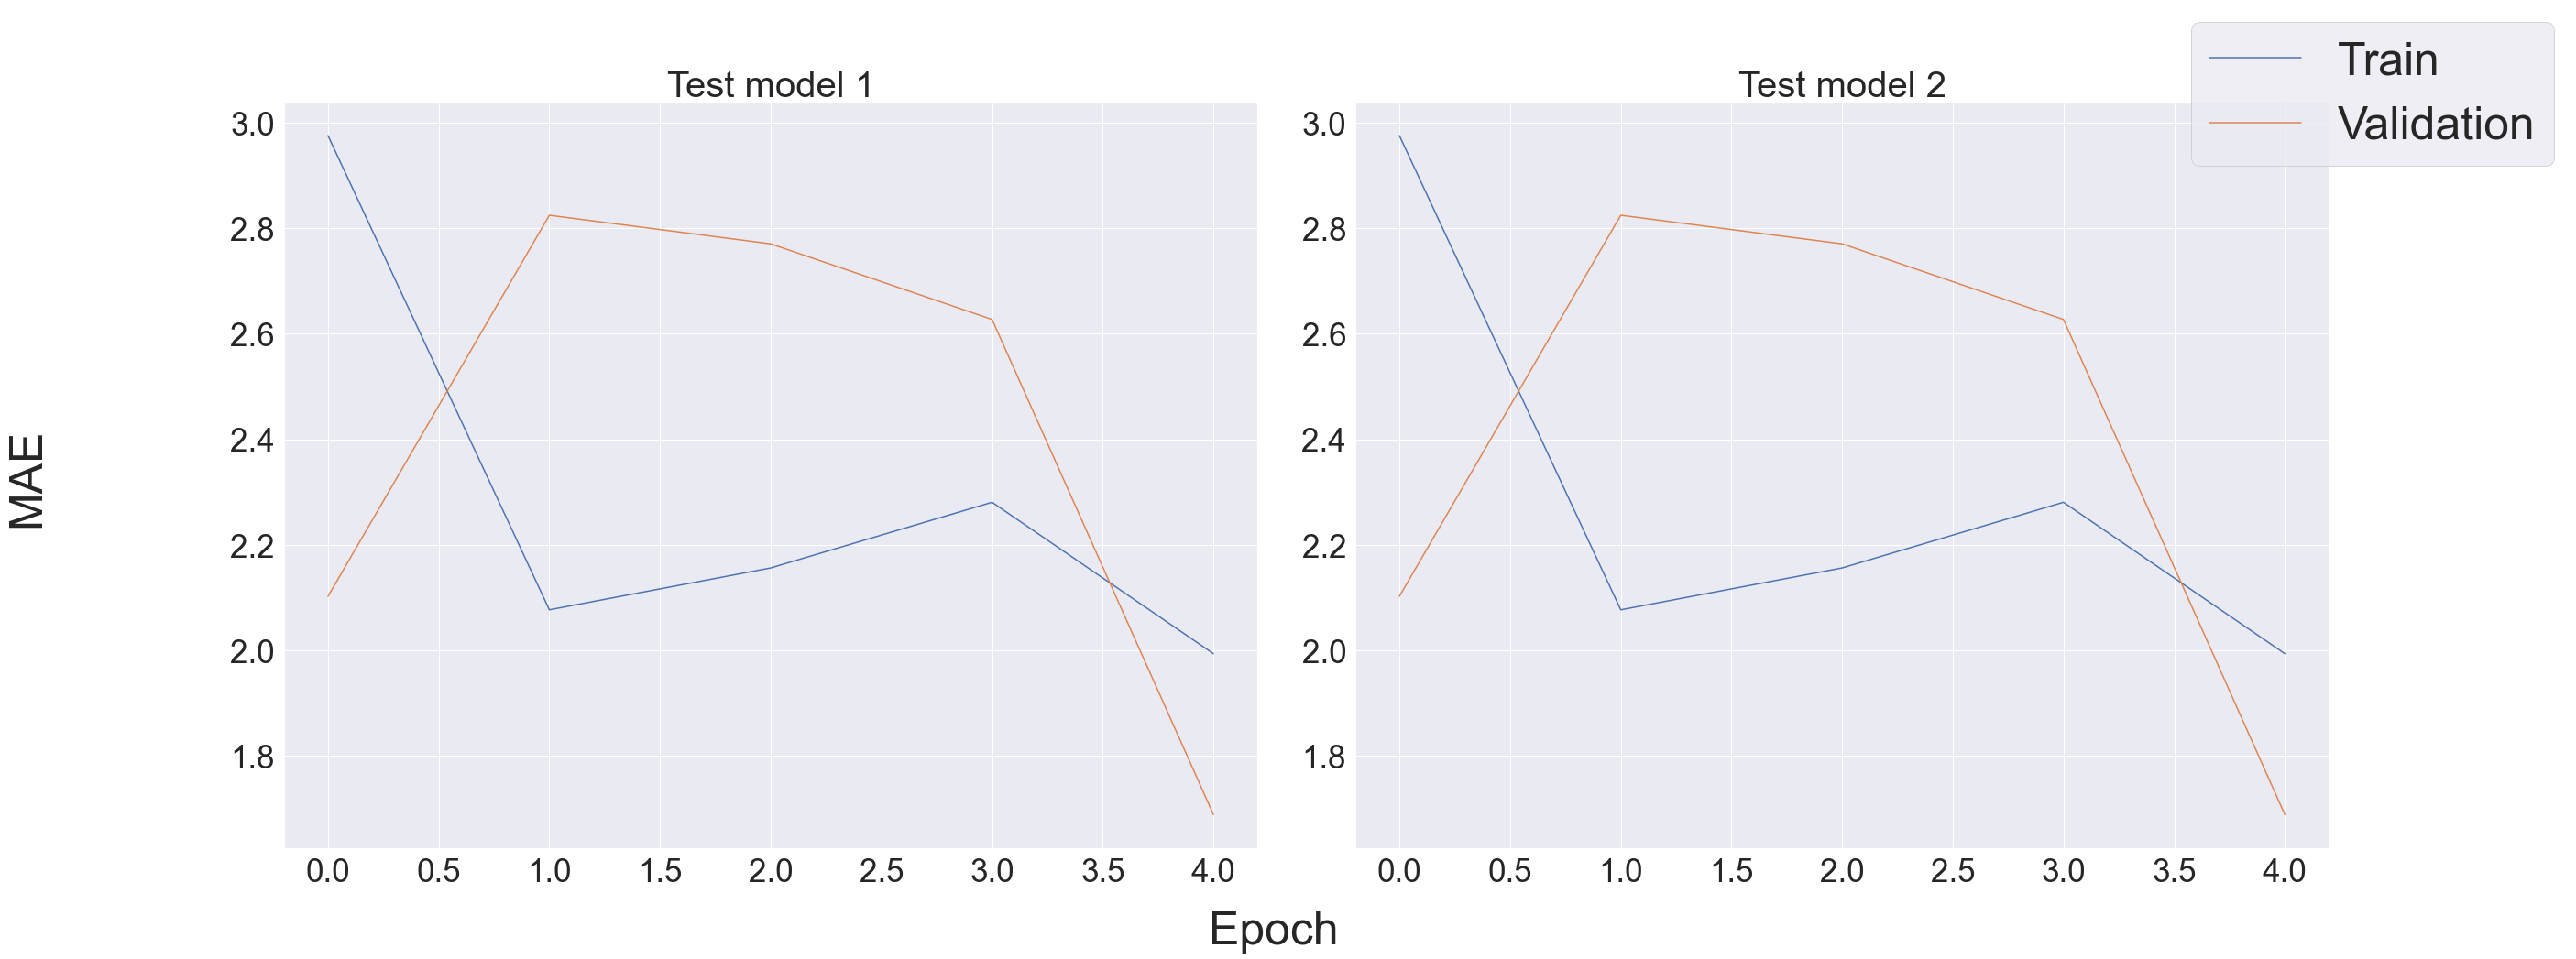

In [32]:
# Prints a set of models
sns.set_theme()
print_curves(
    ['Test model 1', 'Test model 2'],
    [losses, losses],
    [val_losses, val_losses],
    epochs=5
)

In [6]:
# Gets MAPE values as a dataframe
get_parameter_loss(
    [model, model],
    ['Test model 1', 'Test model 2'],
    test_loader,
    scaler
)

,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Test model 1,10.378654,86.689423,0.361873,2.361211,74.143089,127.944275,50.313087
Test model 2,10.319891,86.893860,0.351447,2.244502,74.183807,127.754807,50.291378


In [7]:
df = get_parameter_loss(
    [model, model],
    ['Test model 1', 'Test model 2'],
    test_loader,
    scaler
)

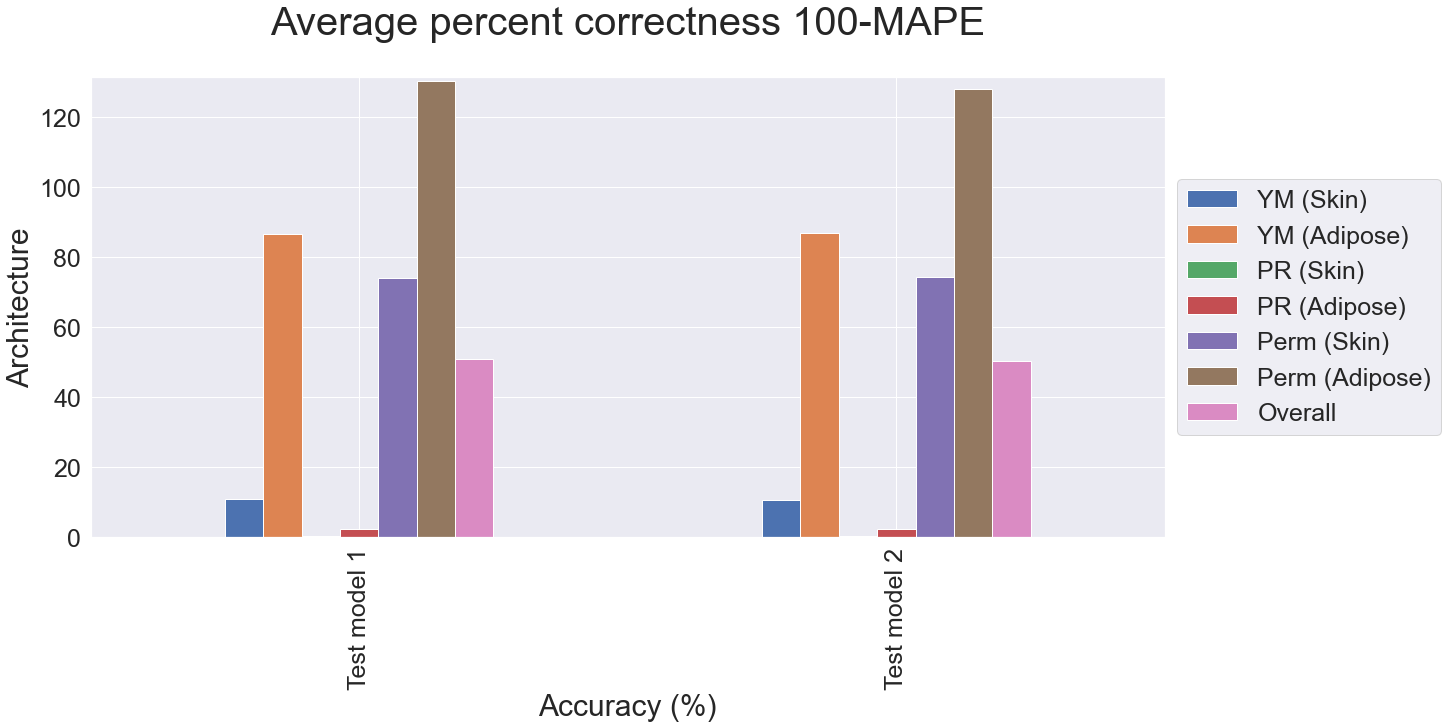

In [15]:
sns.set_theme()
plot_parameter_bars(
    df,
    fname=None, # Saves to file if given
    max_y=max(df.max()) + 1
)